In [1]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
from tqdm import tqdm
from pathlib import Path

device = "cuda" if torch.cuda.is_available() else "cpu"

model_name = "openai/clip-vit-base-patch32"
processor = CLIPProcessor.from_pretrained(model_name)
model = CLIPModel.from_pretrained(model_name).to(device)
model.eval()


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [6]:
def get_cifar10_clip_embeddings(
    images,
    model,
    processor,
    batch_size=64,
    device="cuda"
):
    all_embs = []

    for i in range(0, len(images), batch_size):
        batch_imgs = images[i:i+batch_size]

        inputs = processor(
            images=batch_imgs,
            return_tensors="pt",
            padding=True
        ).to(device)

        with torch.no_grad():
            feats = model.get_image_features(**inputs)
            feats = torch.nn.functional.normalize(feats, dim=1)

        all_embs.append(feats.cpu())

    return torch.cat(all_embs)


In [3]:
import torchvision
from torch.utils.data import DataLoader
from PIL import Image

cifar = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True
)

# CIFAR returns (PIL image, label) by default
images = [img for img, _ in cifar]
true_labels = [label for _, label in cifar]

class_names = cifar.classes



100%|██████████| 170M/170M [00:11<00:00, 15.3MB/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data


In [7]:
embeddings = get_cifar10_clip_embeddings(
    images,
    model,
    processor,
    batch_size=64,
    device=device
)

print(embeddings.shape)
# (10000, 512)


torch.Size([10000, 512])


In [ ]:
domain_embeddings = {}

for iamges, domain in zip(images, true_labels):
    print(f'Encoding domain: {domain}')
    embs = get_cifar10_clip_embeddings(images, model, tokenizer)
    domain_embeddings[domain] = embs

In [ ]:
domain_centroids = {
    domain: torch.mean(embs, dim=0)
    from domain, embs in zip(true_labels, images)
}

In [ ]:
for d in domain_centroids:
    domain_centroids[d] = torch.nn.functional.normalize(domain_centroids[d], p=2, dim=0)

In [ ]:
torch.save(domain_embeddings, "domain_embeddings.pt")
torch.save(domain_centroids, "domain_centroids.pt")

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=128, random_state=42)
embeddings_pca = pca.fit_transform(embeddings.numpy())


In [16]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, n_init=20, random_state=42)
pred_labels = kmeans.fit_predict(embeddings_pca)


In [17]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

nmi = normalized_mutual_info_score(true_labels, pred_labels)
ari = adjusted_rand_score(true_labels, pred_labels)

print(f"NMI: {nmi:.3f}")
print(f"ARI: {ari:.3f}")


NMI: 0.579
ARI: 0.330


In [20]:
import umap
import numpy as np

reducer = umap.UMAP(
    n_neighbors=4,
    min_dist=0.1,
    n_components=2,
    metric="cosine",
    random_state=42
)

emb_2d = reducer.fit_transform(embeddings.numpy())


c:\Users\jbmcg\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


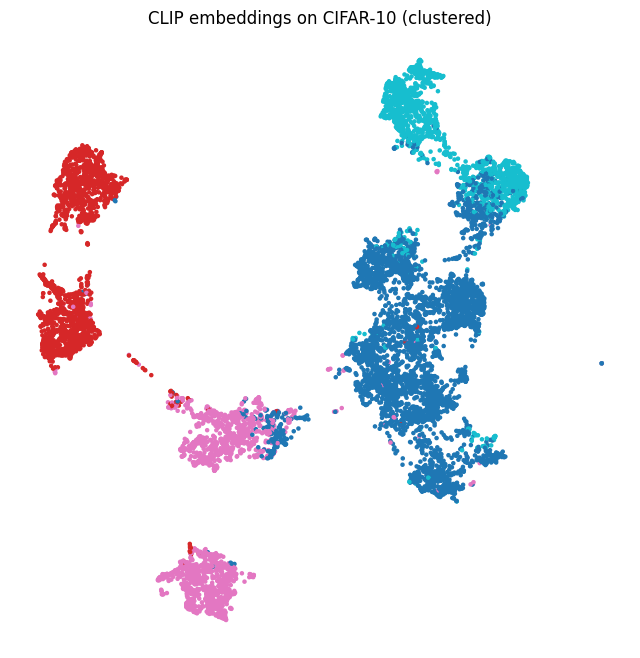

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
scatter = plt.scatter(
    emb_2d[:, 0],
    emb_2d[:, 1],
    c=pred_labels,
    s=5,
    cmap="tab10"
)
plt.title("CLIP embeddings on CIFAR-10 (clustered)")
plt.axis("off")
plt.show()


In [22]:
import random
import matplotlib.pyplot as plt

def show_cluster_images(
    images,
    labels,
    cluster_id,
    n=25
):
    idxs = [i for i, l in enumerate(labels) if l == cluster_id]
    idxs = random.sample(idxs, min(n, len(idxs)))

    plt.figure(figsize=(5, 5))
    for i, idx in enumerate(idxs):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[idx])
        plt.axis("off")
    plt.suptitle(f"Cluster {cluster_id}")
    plt.show()


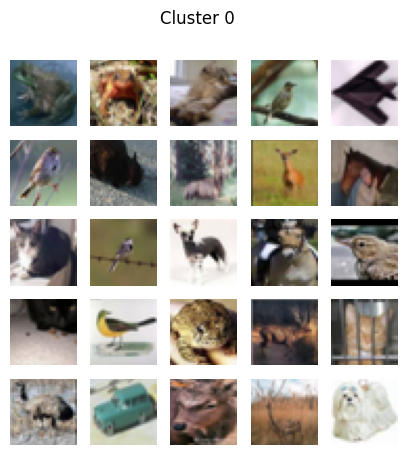

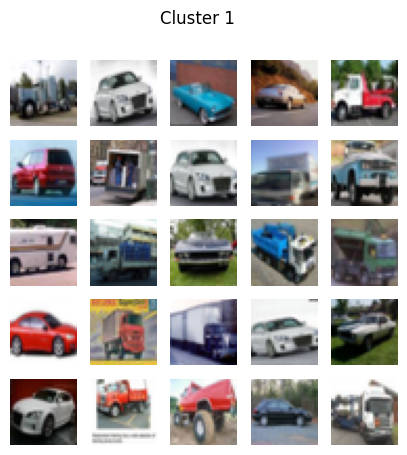

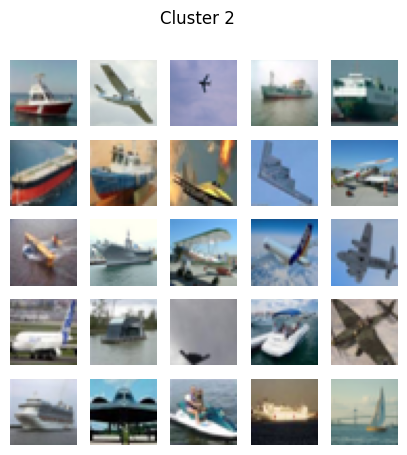

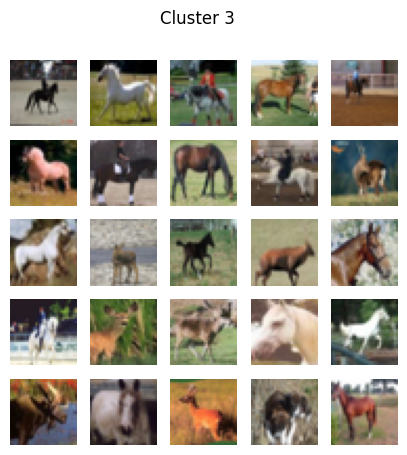

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [23]:
for k in range(10):
    show_cluster_images(images, pred_labels, k)